<a href="https://colab.research.google.com/github/MetronWard/hands_on_ml/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initializing Kaggle


In [1]:
!mkdir ~/.kaggle

In [2]:
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

# Downloading Dataset

In [4]:
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

100% 67.4k/67.4k [00:00<00:00, 620kB/s]
100% 67.4k/67.4k [00:00<00:00, 611kB/s]


In [5]:
from zipfile import ZipFile

zip_file = ZipFile("/content/stroke-prediction-dataset.zip")
zip_file.extractall()
zip_file.close()

# Loading Data

In [6]:
import pandas as pd

stroke = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")
stroke.drop("id", axis=1, inplace=True)

In [7]:
stroke.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


In [8]:
# Missing Data

stroke.isnull().sum() / stroke.count() * 100

gender               0.00000
age                  0.00000
hypertension         0.00000
heart_disease        0.00000
ever_married         0.00000
work_type            0.00000
Residence_type       0.00000
avg_glucose_level    0.00000
bmi                  4.09452
smoking_status       0.00000
stroke               0.00000
dtype: float64

In [9]:
stroke.duplicated().sum()

0

In [10]:
stroke.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


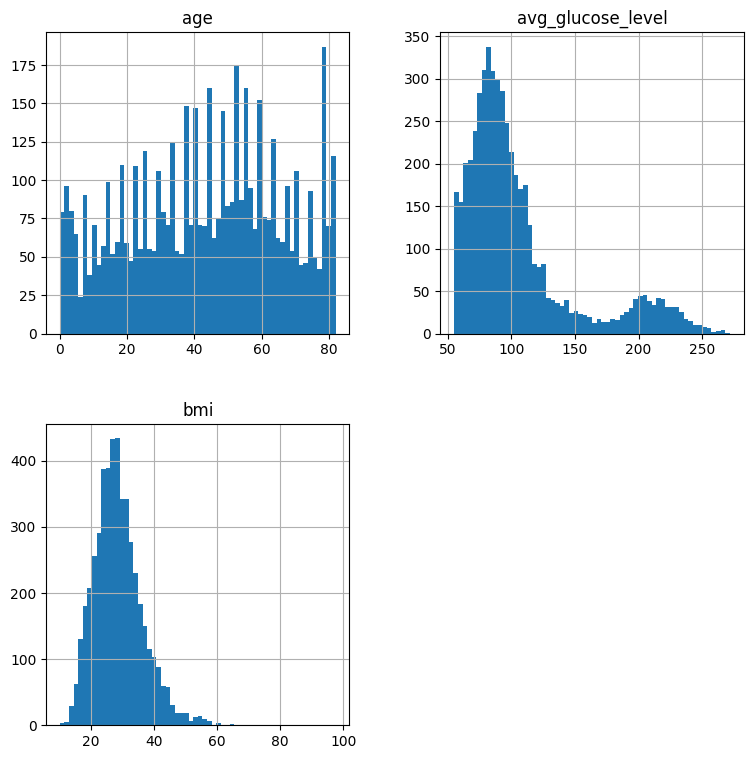

In [11]:
nums = ["age", "avg_glucose_level", "bmi"]
stroke[nums].hist(bins=60, figsize=(9,9));

In [12]:
for col in stroke.columns:
  if col not in nums:
    print(stroke[col].value_counts())
    print("")

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

0    4612
1     498
Name: hypertension, dtype: int64

0    4834
1     276
Name: heart_disease, dtype: int64

Yes    3353
No     1757
Name: ever_married, dtype: int64

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

0    4861
1     249
Name: stroke, dtype: int64



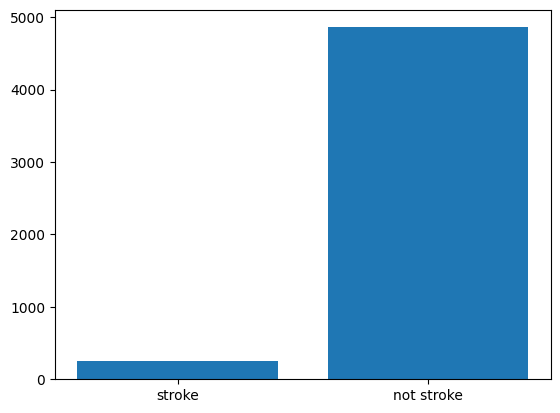

In [13]:
target_1 = len(stroke[stroke["stroke"] == 1])
target_0 = len(stroke[stroke["stroke"] == 0])

import matplotlib.pyplot as plt

plt.bar(x=["stroke","not stroke"], height=[target_1, target_0]);

Because of the ratio of stroke to non stroke patients, it is better use an oversampling technique to improve the chances of making any meaningful predictions

In [14]:
stroke.corr()["stroke"].sort_values(ascending=False)

<ipython-input-14-1a2c2433421b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  stroke.corr()["stroke"].sort_values(ascending=False)


stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
Name: stroke, dtype: float64

# Train test split

In [15]:
from sklearn.model_selection import train_test_split
x = stroke.drop("stroke", axis=1)
y = stroke["stroke"].copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [16]:
x_train.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

 # Defining a Pipeline

In [17]:
cats = [item for item in x_train.columns if item not in nums]

In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("nums_transformer", num_pipeline, nums),
    ("cat_transformer", OneHotEncoder(handle_unknown="ignore"), cats)
])

In [19]:
x_train_processed = full_pipeline.fit_transform(x_train)

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_train_processed, y_train)

In [21]:
print(f"The shape of the original training dataset is {x_train_processed.shape}")
print(f"The shape of the oversampled training dataset is {x_smote.shape}")

The shape of the original training dataset is (3577, 22)
The shape of the oversampled training dataset is (6834, 22)


# Training Models

## Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(random_state=42)
logistic_reg.fit(x_smote, y_smote)

LogisticRegression(random_state=42)

In [23]:
from sklearn.model_selection import cross_val_score

log_reg_score = cross_val_score(logistic_reg, x_smote, y_smote, scoring="accuracy")

In [24]:
log_reg_score

array([0.78419898, 0.78931968, 0.79151426, 0.79151426, 0.79648609])

## SVM

In [25]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(x_smote, y_smote)

SVC()

In [26]:
svc_scores = cross_val_score(svm_clf, x_smote, y_smote, scoring="accuracy")

In [27]:
svc_scores

array([0.88222385, 0.90855889, 0.9012436 , 0.88953914, 0.90775988])

## Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

rand_frst = RandomForestClassifier(random_state=42)
rand_frst.fit(x_smote, y_smote)

RandomForestClassifier(random_state=42)

In [29]:
rand_frst_scores = cross_val_score(rand_frst, x_smote, y_smote, scoring="accuracy")

In [30]:
rand_frst_scores

array([0.92611558, 0.98098025, 0.98098025, 0.9722019 , 0.98096633])

## XGBOOST

In [31]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_smote, y_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
xgb_scores = cross_val_score(xgb, x_smote, y_smote)

In [33]:
xgb_scores

array([0.91075347, 0.97512802, 0.96927579, 0.9722019 , 0.977306  ])

# Comparing Models

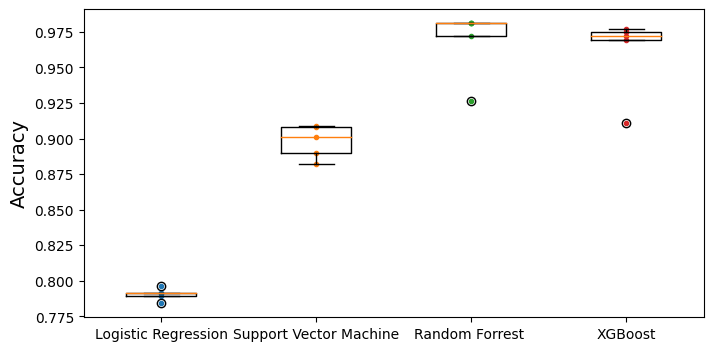

In [34]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*5, log_reg_score, ".")
plt.plot([2]*5, svc_scores, ".")
plt.plot([3]*5, rand_frst_scores, ".")
plt.plot([4]*5, xgb_scores, ".")
plt.boxplot([log_reg_score, svc_scores, rand_frst_scores, xgb_scores], labels=("Logistic Regression","Support Vector Machine", "Random Forrest ", "XGBoost"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

# Testing the model

In [35]:
x_test_prepared = full_pipeline.transform(x_test)

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

preds = xgb.predict(x_test_prepared)

In [50]:
print(classification_report(y_test, preds, target_names=["Stroke", "Not stroke"]))

              precision    recall  f1-score   support

      Stroke       0.94      0.98      0.96      1444
  Not stroke       0.17      0.07      0.10        89

    accuracy                           0.93      1533
   macro avg       0.56      0.52      0.53      1533
weighted avg       0.90      0.93      0.91      1533



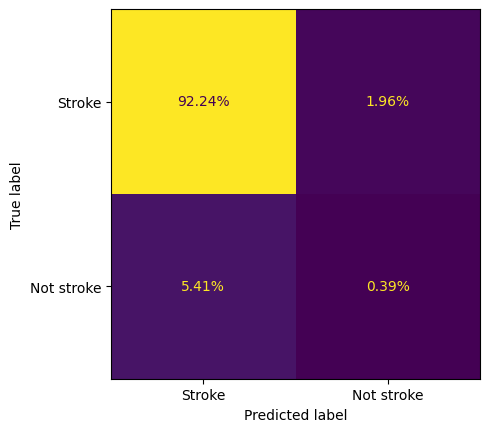

In [51]:
cm = ConfusionMatrixDisplay(
    confusion_matrix(
        y_true=y_test,
        y_pred=preds,
        normalize='all'
    ),
    display_labels=["Stroke", "Not stroke"],
)

# Plot the confusion matrix with specified formatting
cm.plot(
    values_format='.2%',  # Display values as percentages with two decimal places
    colorbar=False,  # Do not display the color bar
)

# Display the confusion matrix plot
plt.show()

# Tensorflow

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense

In [40]:
x_train_processed.shape

(3577, 22)

In [41]:
model_1 = Sequential([
    InputLayer(input_shape=[22]),
    Dense(22, activation="elu", kernel_initializer="he_normal", name="Dense_1"),
    Dense(10, activation="elu", kernel_initializer="he_normal", name="Dense_2"),
    Dense(5, activation="elu", kernel_initializer="he_normal", name="Dense_3"),
    Dense(1, activation="sigmoid")
])

In [42]:
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer="sgd")

In [43]:
model_1.fit(x_smote, y_smote, epochs=60)

Epoch 1/60
214/214 [==============================] - 1s 2ms/step - loss: 0.6166
Epoch 2/60
214/214 [==============================] - 0s 2ms/step - loss: 0.5094
Epoch 3/60
214/214 [==============================] - 0s 2ms/step - loss: 0.4815
Epoch 4/60
214/214 [==============================] - 0s 2ms/step - loss: 0.4686
Epoch 5/60
214/214 [==============================] - 0s 2ms/step - loss: 0.4610
Epoch 6/60
214/214 [==============================] - 0s 2ms/step - loss: 0.4565
Epoch 7/60
214/214 [==============================] - 0s 2ms/step - loss: 0.4534
Epoch 8/60
214/214 [==============================] - 0s 2ms/step - loss: 0.4506
Epoch 9/60
214/214 [==============================] - 0s 2ms/step - loss: 0.4486
Epoch 10/60
214/214 [==============================] - 0s 2ms/step - loss: 0.4470
Epoch 11/60
214/214 [==============================] - 0s 2ms/step - loss: 0.4448
Epoch 12/60
214/214 [==============================] - 0s 2ms/step - loss: 0.4432
Epoch 13/60
214/214 [====

In [44]:
x_test_prepared = full_pipeline.transform(x_test)

In [45]:
model_1.evaluate(x_test_prepared, y_test)

48/48 [==============================] - 0s 2ms/step - loss: 0.4902


0.4902380704879761

In [46]:
preds = (model_1.predict(x_test_prepared) >= 0.5)

48/48 [==============================] - 0s 2ms/step


In [47]:
print(classification_report(y_test, preds, target_names=["Stroke", "Not stroke"]))

              precision    recall  f1-score   support

      Stroke       0.98      0.75      0.85      1444
  Not stroke       0.15      0.72      0.25        89

    accuracy                           0.74      1533
   macro avg       0.56      0.73      0.55      1533
weighted avg       0.93      0.74      0.81      1533



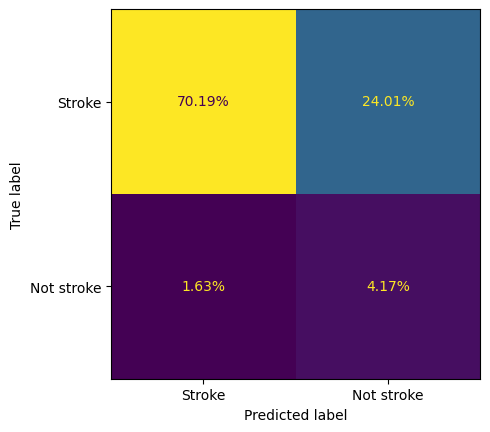

In [48]:
cm = ConfusionMatrixDisplay(
    confusion_matrix(
        y_true=y_test,
        y_pred=preds,
        normalize='all'
    ),
    display_labels=["Stroke", "Not stroke"],
)

# Plot the confusion matrix with specified formatting
cm.plot(
    values_format='.2%',  # Display values as percentages with two decimal places
    colorbar=False,  # Do not display the color bar
)

# Display the confusion matrix plot
plt.show()